## LSTM (long short-term memory) based Recurrent NeuralNet for share price forecasting
###### Abdulla Al Blooshi
----------------
- As an overview, the idea behind this model architecture is to assign weights to selected features; in this case the **open** and the **highest** price the stock reached for a given day were selected. These learned weights represents the model's view on the importance of said features from recent and previous time blocks and how they affect the price in the coming day(s).
- This model will be trained on ADNOC's stock price history and the weights it learns will be saved and used via a transfer learning approach to be tested on and predict Borouge's future stock price.
- This was done due to the lack of training data for Borouge's stock price as it (relatively) recently IPO'd
<br>
<br>
> *This is by no means financial advice as I am not a financial expert, and all the data used here is publicly available.*

In [15]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from tensorflow import keras
# from keras.optimizers import SGD
from keras.models import Sequential, save_model
from keras.layers import (
    Dense,
    Dropout,
    LSTM
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

#### Splitting and normalizing the data:
   - It is easier for the model to work with numbers that are closer together; namely in the range of (0,1) for our case
   - The `MinMaxScaler()` transformation is given by:
      
        X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))<br>
        X_scaled = X_std * (max - min) + min <br>
        
        *where min, max = feature_range.*
        > taken straight from the docs

In [16]:
# unsplit_dat = pd.read_csv('./data/ADNOCDIST_Historical_Data.csv', index_col='Date')

unsplit_dat = pd.read_csv('./data/ADNOCDIST_Historical_Data.csv')
#?Aside:: df.index = pd.to_datetime(df['colName], format='%m %d, %Y')

#* Shuffle (param in train_test_split) set to false for smaller dataset to avoid sampling bias, default behavior is shuffle first then split
# Shuffle changed back to default behavior, because the trend over the dataset from the start is increasing.
# having shuffle flag set to true will lead to said sampling bias, earlier (2016-17) values are only around 2

# !removed randomstate kwarg
training_set, valid_and_test_set = train_test_split(unsplit_dat[['Open']].values, train_size=0.80, shuffle=False)

test_set, valid_set = train_test_split(valid_and_test_set, test_size=0.7, shuffle=False)

normalizer = MinMaxScaler(feature_range=(0.0015,1))
# norm2 = StandardScaler()
# scaledvalid2 = norm2.fit_transform(valid_set)

scaled_train_set = normalizer.fit_transform(training_set)
scaled_valid_set = normalizer.fit_transform(valid_set)

print(f"Training set:\n{scaled_train_set[:5]}\nValidation set:\n{scaled_valid_set[:5]}\nTest set:\n{test_set[:5]}")
training_set.shape, test_set.shape, valid_set.shape

Training set:
[[0.89682167]
 [0.86686667]
 [0.85688167]
 [0.86686667]
 [0.85688167]]
Validation set:
[[0.25973276]
 [0.31137931]
 [0.31137931]
 [0.31137931]
 [0.31137931]]
Test set:
[[2.39]
 [2.43]
 [2.37]
 [2.37]
 [2.37]]


((936, 1), (70, 1), (165, 1))

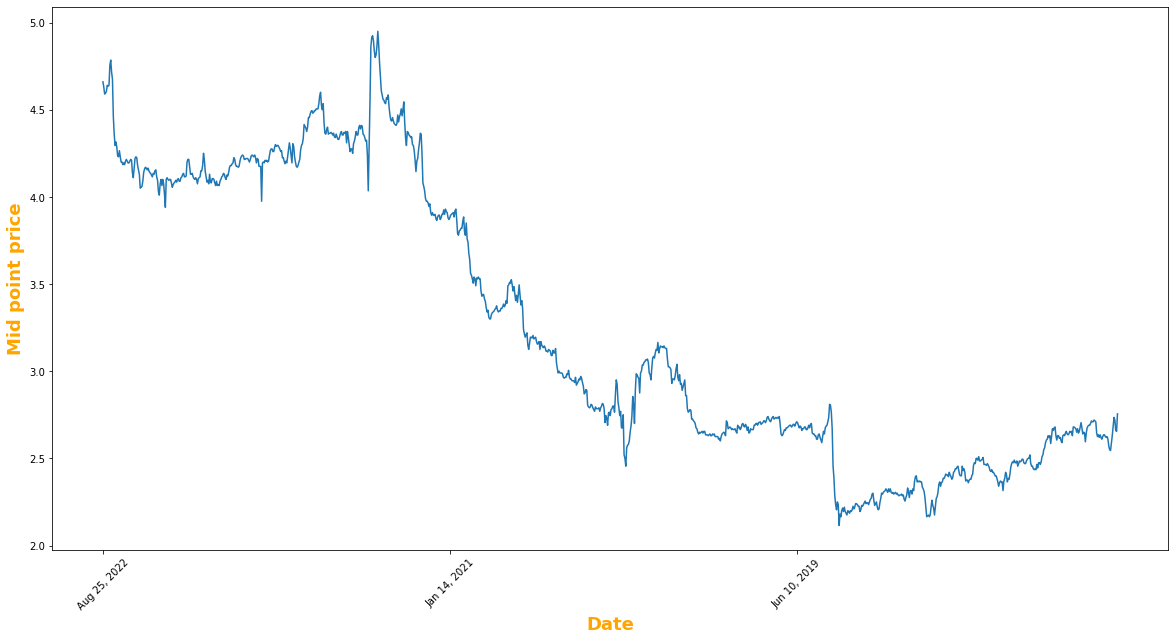

In [17]:
plt.figure(figsize=(20,10))
plt.plot(range(unsplit_dat.shape[0]),(unsplit_dat['Low']+unsplit_dat['High'])/2.0)
plt.xticks(range(0,unsplit_dat.shape[0],400),unsplit_dat['Date'].loc[::400], rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid point price',fontsize=18)
plt.rcParams['axes.labelcolor']='orange'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.labelweight']='bold'
plt.show()
plt.close()

In [18]:
from scipy import stats
import math 
stat, p = stats.normaltest(unsplit_dat['Open'].values)

print('Stats=%.3f, p=%.3f' % (stat, p))
alpha = 0.05

if p>alpha:
    print('Gaussian dist')
else:
    print('sh*t')

Stats=10851.778, p=0.000
sh*t


#### LSTMs distinguishing features and other important notes:
- As per the [paper](http://www.bioinf.jku.at/publications/older/2604.pdf) first proposing this architecture by Hochreiter et al. Constant error carousels (CEC) are the central features of LSTMs. Controlling (deciding) the backward propagation of errors through the network.
    - These CEC's are then extended to form what is referred to as a memory cell; the extension adds multiplicative input and output gates. These gates control the contents with in a cell from being propagated and control the cell from activating other units respectively.
- RNNs are able to use recently seen past information however, they cannot do so with data that has larger time windows between its elements. This is where the LSTM architecture comes into play.
- This is another one of the distinguishing features of using the LSTM architecture, its ability to 'remember' or erase parts of previously seen data in a window (or timestep).
- By creating a window our training data will be turned into an array of arrays divided into chunks of N, where N would be the size of our timestep/window.
    - for example having N = 60 would allow our model to use the previous sixty days of data to make the prediction for the 61st.


In [19]:
#TODO: y_train should predict close prices?
#TODO: Consider using sklearn's standardScaler()?
X_train=[]
y_train=[]
X_valid=[]
y_valid=[]
# twenty two day sliding window X_train ➡ [[day0-21],[day1-22],[day2-23]...]
# y_train ➡ [day22, day23, day24...] 
# Which means the label (ie true/observed value) for X_trains first sample is the 23rd day.

for i in range(22,scaled_train_set.shape[0]):
    X_train.append(scaled_train_set[i-22:i,0])
    y_train.append(scaled_train_set[i,0])
# to pred past the 22nd day change the offset for i
# ie: if sliding window is 30days i-20 for 10 day forecast?

for j in range(22,scaled_valid_set.shape[0]):
    X_valid.append(scaled_valid_set[j-22:j,0])
    y_valid.append(scaled_valid_set[j,0])

# Keras accepts numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid) 

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((914, 22), (914,), (143, 22), (143,))

In [20]:
# A = list(zip(X_train))

#### Implementation Notes:
- The model base architecture will be sequential which ["_groups a linear stack of layers into a tf.keras.Model_"](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
- Ideally I would've liked to add more dropout layers but I do not have that luxury as data is limited. The dropout layers aids in reducing the amount of overfitting.

___However, before we can do that the data must be transformed further into a 3D array with X_train learning examples. In our case it will be of dimension (973,22,1), the 973 comes from the number of samples we have, the 22 is because we grouped our samples into time frames of 22, and the 1 is because we are considering only one feature from the entire dataset___


In [21]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_valid = np.reshape(X_valid,(X_valid.shape[0],X_valid.shape[1],1))

In [22]:
# 3rd dimension of 1 represents the number of features we are allowing to weigh, in this case it is one. Namely, the opening price.
X_train.shape, X_valid.shape

((914, 22, 1), (143, 22, 1))

In [23]:
# maybe its the 1.0 vals in X_train
u = np.mean(X_train[X_train>0])

# X_valid[X_valid==1.0]=u
u
# X_train[X_train==1.0]=u

0.4825075619156555

In [24]:
# from keras.optimizers import SGD
# from keras.utils.generic_utils import get_custom_objects
# from keras import backend as K 
# from keras.layers import Activation

# def custom_activation(x, beta=1): 
#     return (K.sigmoid(beta*x)*x)

# get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def generate_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(LSTM(units=100, return_sequences=False, activation='hard_sigmoid'))
    # model.add(Dropout(0.05))
    # model.add(Dense(units=25))
    # model.add(Activation(custom_activation,name='tmp'))

    # model.add(Dropout(0.05))
    model.add(Dense(1))
    model.summary()
    # opt = keras.optimizers.Adam(learning_rate=0.01, epsilon=1e-04)

    model.compile(optimizer='adam', loss='mse')
    return model
# get_custom_objects()

In [25]:
lstm_model = generate_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 22, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


#### Training the model on the data:

In [27]:
%%time
#The accuracy is not changing, maybe hinting that the optimizer has found a local minimum. IDK what to do but shall find out...
history = lstm_model.fit(X_train, y_train, epochs=22,batch_size=32,validation_data=(X_valid,y_valid), verbose=1)
# learner = lstm_model.fit(X_train, y_train, epochs=100,batch_size=32, verbose=2)

Epoch 1/22
29/29 [==============================] - 3s 110ms/step - loss: 0.0050 - val_loss: 0.0124
Epoch 2/22
29/29 [==============================] - 3s 95ms/step - loss: 0.0013 - val_loss: 0.0100
Epoch 3/22
29/29 [==============================] - 3s 111ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 4/22
29/29 [==============================] - 3s 108ms/step - loss: 0.0013 - val_loss: 0.0099
Epoch 5/22
29/29 [==============================] - 3s 108ms/step - loss: 0.0012 - val_loss: 0.0101
Epoch 6/22
29/29 [==============================] - 3s 108ms/step - loss: 0.0015 - val_loss: 0.0096
Epoch 7/22
29/29 [==============================] - 3s 109ms/step - loss: 0.0011 - val_loss: 0.0082
Epoch 8/22
29/29 [==============================] - 3s 109ms/step - loss: 0.0012 - val_loss: 0.0104
Epoch 9/22
29/29 [==============================] - 3s 107ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 10/22
29/29 [==============================] - 3s 108ms/step - loss: 0.0011 - val_loss: 0.0080


#### Testing the model on unseen data

- After training the validation loss is reasonably larger than loss on the training set, hinting towards the possibility of underfitting 
- Possible solutions are:
    - Parameter increase
    - Additional layers of
    - Increased training set size

In [28]:
# total_set = unsplit_dat[['Open']].values
# len(scaled_total_set)-len(scaled_test_set)-60 = 963 = X_train.shape[0], the remaining being test
# tests=total_set[len(total_set)-len(test_set)-60:]


test_set = test_set.reshape(-1,1)
# tests = normalizer.transform(tests)
test_set = normalizer.fit_transform(test_set)

X_test=[]
y_test=[]
# # Creating the same window and dimensions as before
for e in range(22,test_set.shape[0]):
    X_test.append(test_set[e-22:e,0])
    y_test.append(test_set[e,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

model_prediction = lstm_model.predict(X_test)
model_prediction = normalizer.inverse_transform(model_prediction)
model_prediction.shape
# model_prediction.reshape(-1)

2/2 [==============================] - 0s 69ms/step


(48, 1)

In [29]:
# RMSE rudiment 
rootmse = np.sqrt(np.mean(model_prediction-y_test)**2)
rootmse

1.6357147077015466

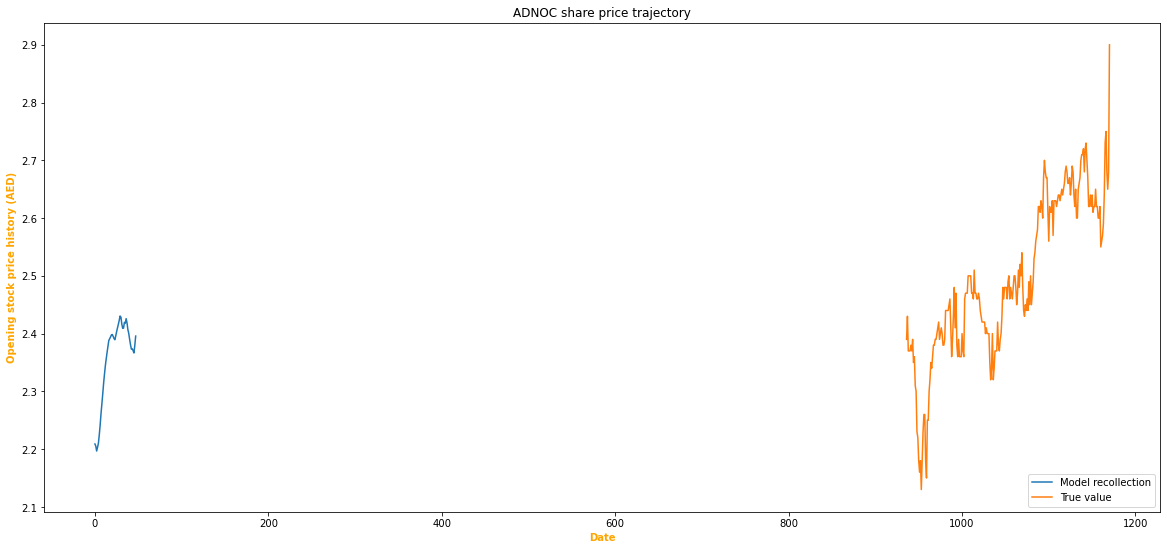

In [52]:
# TODO: Somethings def wrong w the slicing. Quick fix.
totalset = unsplit_dat.filter(['Open'])
# plt.plot(unsplit_dat[['Open']], color='orange',label='adnoc true share price')
trainedData = totalset[len(training_set):]
evalDat = totalset[:len(training_set)]
forecast = model_prediction
plt.figure(figsize=(20,9))

plt.title('ADNOC share price trajectory')
plt.xlabel('Date')
plt.ylabel('Opening stock price history (AED)')
plt.plot(model_prediction)
plt.plot(trainedData)
# plt.plot(evalDat)
plt.legend(['Model recollection', 'True value', 'Model forecast'], loc='lower right')
# plt.legend(['Used history', 'True value', 'Model forecast'], loc='lower right')
# evaluationData = unsplit_dat[valid_and_test_set.shape[0]:]

# plt.plot(model_prediction, color='black',label='model prediction')
plt.show()

In [ ]:
lstm_model.save('transferable.h5')

# This is an aside
----------
### Testing if the model shows better results with different, more abundant data ??

In [ ]:
GOOGdat = pd.read_csv('./data/GOOG.csv', index_col='Date')
trainSet, validAndTestSet = train_test_split(GOOGdat.iloc[:,1:2].values, train_size=0.8)
testingSet, validationSet = train_test_split(validAndTestSet, test_size=0.5)
trainSet.shape, testingSet.shape, validationSet.shape, GOOGdat.shape

normer = MinMaxScaler(feature_range=(0,1))
trScaled = normer.fit_transform(trainSet)
valScaled = normer.transform(validationSet)

In [ ]:
X_tr, y_tr, X_val, y_val = [], [], [], []

for g in range(30, trScaled.shape[0]):
    X_tr.append(trScaled[g-30:g,0])
    y_tr.append(trScaled[g,0])
for t in range(30, valScaled.shape[0]):
    X_val.append(valScaled[t-30:t,0])
    y_val.append(valScaled[t,0])
X_tr, y_tr, X_val, y_val = np.array(X_tr), np.array(y_tr), np.array(X_val), np.array(y_val)

X_tr = np.reshape(X_tr, (X_tr.shape[0], X_tr.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

X_tr.shape, X_val.shape

((3600, 30, 1), (424, 30, 1))

In [ ]:
def generate_model2():
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, input_shape=(X_tr.shape[1],1)))
    # model.add(Dropout(0.1))
    model.add(LSTM(units=10, return_sequences=True))
    # model.add(Dropout(0.05))
    # model.add(LSTM(units=10, return_sequences=False))
    # model.add(Activation(custom_activation,name='tmp'))

    # model.add(Dropout(0.05))
    model.add(Dense(units=1))
    model.summary()
    opt = keras.optimizers.Adam(learning_rate=0.01, epsilon=1e-04)
    model.compile(optimizer='adam', loss='mse')

    return model

In [ ]:
# googLstm = generate_model2()
# estimator = googLstm.fit(X_tr, y_tr, epochs=100, batch_size=32, validation_data=(X_val,y_val), verbose=2)

<ul style="color:orange">
<li>TODO: ExponMovingAvg for comparison</li>
<li>TODO: Data visualization</li>
<li>TODO: Save model and use transfer learning to apply to Borouge stock</li>
</ul>